In [1]:
# Nice tutorial on propensity score matching (psm): https://ehsanx.github.io/psw/index.html#description

In [1]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import configparser
import sqlite3
import math
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# from streamlit_dashboard.causal_cluster import df_data
from streamlit_dashboard.causal_cluster_helper import DataLoader, HypothesisTestHelper, FollowUpFilter
from psm_helper import PsmHelper, OBSERVATIONAL_CLASSES

import scienceplots

# plt.style.use('science')
plt.style.use('classic')

sns.set()  # set the style

In [3]:
config = configparser.ConfigParser()
config.read('../../data/config/local_config.ini')
conn = sqlite3.connect(config['DATABASE']['path'])

In [4]:
treatment_var = "is_clinical_question_stated"
patient_characteristics = [
    "age_intervall_0",
    "age_intervall_1",
    "age_intervall_2",
    "M",
    "F"
]

# for icd-code disease: 486 (pneumonia)
disease_icd = [("486", "ICD-9")]

observation_indication_history = [
    ("C0015967", "Fever"),
    ("C0010200", "Coughing"),
    ("C0013404", "Dyspnea"),
    ("C0032285", "Pneumonia"),
    ("C0242184", "Hypoxia"),
    ("C0008031", "Chest Pain"),
    ("C0239134", "Productive Cough"),
    ("C0332271", "Worsening pattern"),
    ("C0024117", "Chronic Obstructive Airway Disease"),
    ("C0018802", "Congestive heart failure"),
    ("C0032227", "Pleural effusion disorder"),
    ("C0242379", "Malignant neoplasm of lung"),
    ("C0019079", "Hemoptysis"),
    ("C0085593", "Chills"),
    ("C0034063", "Pulmonary Edema"),
    ("C0019682", "HIV"),
    ("C0476273", "Respiratory distress"),
    ("C0231835", "Tachypnea"),
    ("C1145670", "Respiratory Failure"),
    ("C0043144", "Wheezing"),
    ("C0034642", "Rales"),
    ("C0004093", "Asthenia"),
    ("C0009676", "Confusion"),
    ("C0189477", "Thoracentesis"),
    ("C0021107", "Implantation procedure"),
    ("C0039231", "Tachycardia"),
    ("C0023518", "Leukocytosis"),
    ("C0007131", "Non-Small Cell Lung Carcinoma"),
    ("C0008033", "Pleuritic pain"),
    ("C0700292", "Hypoxemia"),
    ("C0004238", "Atrial Fibrillation"),
    ("C0000737", "Abdominal Pain"),
    ("C0022661", "Kidney Failure, Chronic"),
    ("C0020649", "Hypotension"),
    ("C0026764", "Multiple Myeloma"),
    ("C0179740", "Peripherally inserted central catheter (physical object)"),
    ("C0029053", "Decreased translucency"),
    ("C0013216", "Pharmacotherapy"),
    ("C0015672", "Fatigue"),
    ("C0349707", "Aspiration-action"),
    ("C0032326", "Pneumothorax"),
    ("C0008034", "Chest Tubes"),
    ("C0021925", "Intubation (procedure)"),
    ("C0023890", "Liver Cirrhosis"),
    ("C4086268", "Exacerbation"),
    ("C1860224", "ABLEPHARON-MACROSTOMIA SYNDROME"),
    ("C0042963", "Vomiting"),
    ("C4698386", "Intubated"),
    ("C0585105", "Right lower zone pneumonia"),
    ("C1261075", "Structure of right lower lobe of lung"),
    ("C0027497", "Nausea"),
    ("C0023530", "Leukopenia"),
    ("C0752151", "Thoracic Surgery, Video-Assisted"),
    ("C0013687", "effusion"),
    ("C0020538", "Hypertensive disease"),
    ("C0746961", "Oxygen saturation below reference range"),
    ("C0040028", "Thrombocythemia, Essential")
]

# top indication/history cuis for follow-up exams with min. 5 exams during a single hospital admission
# observation_indication_history = [
#     ("C0032285", "Pneumonia"),
#     ("C0032227", "Pleural effusion disorder"),
#     ("C0242184", "Hypoxia"),
#     ("C0013404", "Dyspnea"),
#     ("C0024117", "Chronic Obstructive Airway Disease"),
#     ("C1145670", "Respiratory Failure"),
#     ("C0018802", "Congestive heart failure"),
#     ("C0015967", "Fever"),
# ]
# ------------------------------------------------------
# disease_icd = "7865"  # chest pain
# observation_indication_history = [
#     ("C0008031", "Chest Pain"),
#     ("C0013404", "Dyspnea"),
#     ("C0010200", "Coughing"),
#     ("C0006938", "captopril"),
#     ("C0438716", "Chest pressure"),
#     ("C0008033", "Pleuritic pain"),
#     ("C0020538", "Hypertensive disease"),
#     ("C0151826", "Retrosternal pain"),
#     ("C0030252", "Palpitations"),
#     ("C0015967", "Fever"),
#     ("C0032285", "Pneumonia"),
#     ("C0232292", "Chest tightness"),
# ]
observation_indication_history_cuis = [x[0] for x in observation_indication_history]
observation_indication_history = observation_indication_history[:15]
observation_indication_history_cuis = observation_indication_history_cuis[:15]

In [1]:
treatment_var = "is_clinical_question_stated"
patient_characteristics = [
    "age_intervall_0",
    "age_intervall_1",
    "age_intervall_2",
    "M",
    "F"
]

# for icd-code disease: 486 (pneumonia)
disease_icd = [("486", "ICD-9"),
               ("J189", "ICD-10")]

observation_indication_history = [
    ("C0015967", "Fever"),
    ("C0010200", "Coughing"),
    ("C0013404", "Dyspnea"),
    ("C0032285", "Pneumonia"),
    ("C0242184", "Hypoxia"),
    ("C0008031", "Chest Pain"),
    ("C0032227", "Pleural effusion disorder"),
    ("C0024117", "Chronic Obstructive Airway Disease"),
    ("C0332271", "Worsening pattern"),
    ("C0018802", "Congestive heart failure"),
    ("C0239134", "Productive Cough"),
    ("C0019079", "Hemoptysis"),
    ("C0242379", "Malignant neoplasm of lung"),
    ("C1145670", "Respiratory Failure"),
    ("C0034063", "Pulmonary Edema"),
    ("C0085593", "Chills"),
    ("C0008034", "Chest Tubes"),
    ("C0004093", "Asthenia"),
    ("C0019682", "HIV"),
    ("C0034642", "Rales"),
    ("C0231835", "Tachypnea"),
    ("C0023518", "Leukocytosis"),
    ("C0476273", "Respiratory distress"),
    ("C0189477", "Thoracentesis"),
    ("C0021107", "Implantation procedure"),
    ("C0700292", "Hypoxemia"),
    ("C0009676", "Confusion"),
    ("C0023890", "Liver Cirrhosis"),
    ("C0039231", "Tachycardia"),
    ("C0043144", "Wheezing"),
    ("C0004238", "Atrial Fibrillation"),
    ("C0022661", "Kidney Failure, Chronic"),
    ("C0032326", "Pneumothorax"),
    ("C0020538", "Hypertensive disease"),
    ("C0000737", "Abdominal Pain"),
    ("C0020649", "Hypotension"),
    ("C4698386", "Intubated"),
    ("C0752151", "Thoracic Surgery, Video-Assisted"),
    ("C0008033", "Pleuritic pain"),
    ("C0007131", "Non-Small Cell Lung Carcinoma"),
    ("C0015672", "Fatigue"),
    ("C0021925", "Intubation (procedure)"),
    ("C0003232", "Antibiotics"),
    ("C0026764", "Multiple Myeloma"),
    ("C0029053", "Decreased translucency"),
    ("C0349707", "Aspiration-action"),
    ("C0013687", "effusion"),
    ("C4086268", "Exacerbation"),
    ("C0179740", "Peripherally inserted central catheter (physical object)"),
    ("C0013216", "Pharmacotherapy"),
    ("C0042963", "Vomiting"),
    ("C0206062", "Lung Diseases, Interstitial"),
    ("C0010068", "Coronary heart disease"),
    ("C0279027", "Laser Therapy, Low-Level"),
    ("C0023530", "Leukopenia"),
    ("C0027497", "Nausea")
]

observation_indication_history_cuis = [x[0] for x in observation_indication_history]
observation_indication_history = observation_indication_history[:15]
observation_indication_history_cuis = observation_indication_history_cuis[:15]

In [23]:
treatment_var = "is_clinical_question_stated"
patient_characteristics = [
    "age_intervall_0",
    "age_intervall_1",
    "age_intervall_2",
    "M",
    "F"
]

# for icd-code disease: 511 (pleurisy)
# disease_icd = [("511", "ICD-9")]
disease_icd = [("511", "ICD-9"),
               ("R091", "ICD-10")]

# drop ("C0032326", "Pneumothorax") since it is only mentioned in CQ in the history section but this is wrongly processed on our side. However, it is not a high frequency disease anymore but only high frequency CQ!!
# ("C0189477", "Thoracentesis"): mostly follow-ups!
# ("C0032285", "Pneumonia"): same as for pneumothorax!
# --------------------------------------------------------------------------------------
# after adapting the code for CQ extraction (now also derive CQ from hx section):
#  - Only the SMD of Pneumothorax is out of range (0.2442)
#    todo: lets have a look in the streamlit dashboard what might be the reason for that!

observation_indication_history = [
    ("C0032227", "Pleural effusion disorder"),
    ("C0008034", "Chest Tubes"),
    ("C0013404", "Dyspnea"),
    ("C0189477", "Thoracentesis"),
    ("C0013687", "effusion"),
    ("C0752151", "Thoracic Surgery, Video-Assisted"),
    ("C0189557", "Pleurodesis"),
    # ("C0032326", "Pneumothorax"),
    ("C0007778", "Cerebral Decortication"),
    ("C4054178", "Pigtail Drain"),
    ("C0023890", "Liver Cirrhosis"),
    ("C0021107", "Implantation procedure"),
    ("C0020312", "Hydrothorax"),
    ("C0039989", "Thoracoscopy"),
    ("C0008031", "Chest Pain"),
    ("C0242184", "Hypoxia"),
    # ("C0032285", "Pneumonia"),
    ("C0242379", "Malignant neoplasm of lung"),
    ("C0012621", "Body Fluid Discharge"),
    ("C0278488", "Carcinoma breast stage IV"),
    ("C0039991", "Thoracotomy"),
    ("C0010200", "Coughing"),
    ("C0015967", "Fever"),
    ("C0080032", "Pleural Effusion, Malignant"),
    ("C0332271", "Worsening pattern"),
    ("C0019123", "Hemothorax"),
    ("C0018802", "Congestive heart failure"),
    ("C5237755", "Recurrent Large Pleural Effusion"),
    ("C0020303", "Hydropneumothorax"),
    ("C0006142", "Malignant neoplasm of breast"),
    ("C0189476", "Insertion of pleural tube drain"),
    ("C0007131", "Non-Small Cell Lung Carcinoma"),
    ("C0019196", "Hepatitis C"),
    ("C0010055", "Coronary Artery Bypass Surgery"),
    ("C0014009", "Empyema"),
    ("C0153676", "Secondary malignant neoplasm of lung"),
    ("C0008033", "Pleuritic pain"),
    ("C0176531", "Biopsy of pleura (procedure)"),
    ("C1145670", "Respiratory Failure"),
    ("C0879203", "Pigtail Catheters"),
    ("C0023891", "Liver Cirrhosis, Alcoholic"),
    ("C0034063", "Pulmonary Edema"),
    ("C0278883", "Metastatic melanoma"),
    ("C0024117", "Chronic Obstructive Airway Disease"),
    ("C0035234", "Respiratory Sounds"),
    ("C0231835", "Tachypnea"),
    ("C0010068", "Coronary heart disease"),
    ("C0030899", "pentoxifylline"),
    ("C0018944", "Hematoma"),
    ("C0019682", "HIV"),
    ("C0225778", "Pleural fluid"),
    ("C0022661", "Kidney Failure, Chronic"),
    ("C0007134", "Renal Cell Carcinoma"),
]
observation_indication_history_cuis = [x[0] for x in observation_indication_history]
observation_indication_history = observation_indication_history[:15]
observation_indication_history_cuis = observation_indication_history_cuis[:15]

In [48]:
treatment_var = "is_clinical_question_stated"
patient_characteristics = [
    "age_intervall_0",
    "age_intervall_1",
    "age_intervall_2",
    "M",
    "F"
]

# for icd-code disease: 428 (Heart failure)
disease_icd = [("428", "ICD-9")]

# drop ("C0032285", "Pneumonia") since it is only mentioned in CQ in the history section but this is wrongly processed on our side. However, it is not a high frequency disease anymore but only high frequency CQ!!
# drop ("C0034063", "Pulmonary Edema") party manually observed as CQ or as follow-up (e.g. interval change, ...). But here, wrongly automatically classified as indication/history!!

observation_indication_history = [
    ("C0013404", "Dyspnea"),
    ("C0018802", "Congestive heart failure"),
    ("C0242184", "Hypoxia"),
    ("C0010200", "Coughing"),
    # ("C0032285", "Pneumonia"),
    ("C0032227", "Pleural effusion disorder"),
    ("C0008031", "Chest Pain"),
    ("C0024117", "Chronic Obstructive Airway Disease"),
    # ("C0034063", "Pulmonary Edema"),
    ("C0332271", "Worsening pattern"),
    ("C0018801", "Heart failure"),
    ("C0021107", "Implantation procedure"),
    ("C0015967", "Fever"),
    ("C0020725", "Type II Mucolipidosis"),
    ("C0264716", "Chronic heart failure"),
    ("C0004238", "Atrial Fibrillation"),
    ("C0010068", "Coronary heart disease"),
    ("C0013604", "Edema"),
    ("C0020538", "Hypertensive disease"),
    ("C0013687", "effusion"),
    ("C0003507", "Aortic Valve Stenosis"),
    ("C0189477", "Thoracentesis"),
    ("C0022661", "Kidney Failure, Chronic"),
    ("C0476273", "Respiratory distress"),
    ("C0034642", "Rales"),
    ("C0010055", "Coronary Artery Bypass Surgery"),
    ("C0546817", "Fluid overload"),
    ("C0239340", "Edema of lower extremity"),
    ("C0012797", "Diuresis"),
    ("C0043094", "Weight Gain"),
    ("C0008034", "Chest Tubes"),
    ("C0030163", "Artificial cardiac pacemaker"),
    ("C0032326", "Pneumothorax"),
    ("C0020542", "Pulmonary Hypertension"),
    ("C0036980", "Shock, Cardiogenic"),
    ("C0004093", "Asthenia"),
    ("C0700292", "Hypoxemia"),
    ("C0085619", "Orthopnea"),
    ("C0023518", "Leukocytosis"),
    ("C0043144", "Wheezing"),
    ("C0878544", "Cardiomyopathies"),
    ("C1145670", "Respiratory Failure"),
    ("C0231807", "Dyspnea on exertion"),
    ("C0020649", "Hypotension"),
    ("C0179790", "Pulmonary artery flotation catheter"),
    ("C0239134", "Productive Cough"),
    ("C0010054", "Coronary Arteriosclerosis"),
    ("C0179740", "Peripherally inserted central catheter (physical object)"),
    ("C1561643", "Chronic Kidney Diseases"),
    ("C0020488", "Hypernatremia"),
    ("C0015672", "Fatigue"),
    ("C0021925", "Intubation (procedure)"),
    ("C0086296", "film (photographic)"),
    ("C4698386", "Intubated"),
    ("C1135196", "Heart Failure, Diastolic"),
    ("C0581394", "Swelling of lower limb")
]
observation_indication_history_cuis = [x[0] for x in observation_indication_history]
observation_indication_history = observation_indication_history[:15]
observation_indication_history_cuis = observation_indication_history_cuis[:15]

In [38]:
treatment_var = "is_clinical_question_stated"
patient_characteristics = [
    "age_intervall_0",
    "age_intervall_1",
    "age_intervall_2",
    "M",
    "F"
]

# for icd-code disease: 428, I50 (Heart failure)
disease_icd = [("428", "ICD-9"),
               ("I50", "ICD-10")]

# drop ("C0032285", "Pneumonia") since it is only mentioned in CQ in the history section but this is wrongly processed on our side. However, it is not a high frequency disease anymore but only high frequency CQ!!
# drop ("C0034063", "Pulmonary Edema") party manually observed as CQ or as follow-up (e.g. interval change, ...). But here, wrongly automatically classified as indication/history!!

observation_indication_history = [
    ("C0013404", "Dyspnea"),
    ("C0018802", "Congestive heart failure"),
    ("C0242184", "Hypoxia"),
    ("C0010200", "Coughing"),
    ("C0032227", "Pleural effusion disorder"),
    ("C0008031", "Chest Pain"),
    ("C0024117", "Chronic Obstructive Airway Disease"),
    # ("C0032285", "Pneumonia"),
    ("C0018801", "Heart failure"),
    # ("C0034063", "Pulmonary Edema"),
    ("C0332271", "Worsening pattern"),
    ("C0010068", "Coronary heart disease"),
    ("C0004238", "Atrial Fibrillation"),
    ("C0021107", "Implantation procedure"),
    ("C0020725", "Type II Mucolipidosis"),
    ("C0020538", "Hypertensive disease"),
    ("C0015967", "Fever"),
    ("C0013604", "Edema"),
    ("C0003507", "Aortic Valve Stenosis"),
    ("C0264716", "Chronic heart failure"),
    ("C0010055", "Coronary Artery Bypass Surgery"),
    ("C0022661", "Kidney Failure, Chronic"),
    ("C0013687", "effusion"),
    ("C0036980", "Shock, Cardiogenic"),
    ("C0043094", "Weight Gain"),
    ("C0034642", "Rales"),
    ("C0189477", "Thoracentesis"),
    ("C0476273", "Respiratory distress"),
    ("C0231807", "Dyspnea on exertion"),
    ("C0546817", "Fluid overload"),
    ("C0012797", "Diuresis"),
    ("C0239340", "Edema of lower extremity"),
    ("C0878544", "Cardiomyopathies"),
    ("C0700292", "Hypoxemia"),
    ("C0008034", "Chest Tubes"),
    ("C1145670", "Respiratory Failure"),
    ("C0030163", "Artificial cardiac pacemaker"),
    ("C0004093", "Asthenia"),
    ("C0020649", "Hypotension"),
    ("C0023518", "Leukocytosis"),
    ("C0085619", "Orthopnea"),
    ("C0020542", "Pulmonary Hypertension"),
    ("C0015672", "Fatigue"),
    ("C0179790", "Pulmonary artery flotation catheter"),
    ("C0239134", "Productive Cough"),
    ("C0019829", "Hodgkin Disease"),
    ("C0032326", "Pneumothorax"),
    ("C0004096", "Asthma"),
    ("C0043144", "Wheezing"),
    ("C1561643", "Chronic Kidney Diseases"),
    ("C4698386", "Intubated"),
    ("C0179740", "Peripherally inserted central catheter (physical object)"),
    ("C1135196", "Heart Failure, Diastolic"),
    ("C0020488", "Hypernatremia"),
    ("C0021925", "Intubation (procedure)"),
    ("C0010054", "Coronary Arteriosclerosis"),
]
observation_indication_history_cuis = [x[0] for x in observation_indication_history]
observation_indication_history = observation_indication_history[:15]
observation_indication_history_cuis = observation_indication_history_cuis[:15]

In [54]:
treatment_var = "is_clinical_question_stated"
patient_characteristics = [
    "age_intervall_0",
    "age_intervall_1",
    "age_intervall_2",
    "M",
    "F"
]

# for icd-code disease: 807, S22 (Rip fracture)
disease_icd = [("807", "ICD-9"),
               ("S22", "ICD-10")]


observation_indication_history = [
    ("C0035522", "Rib Fractures"),
    ("C0032326", "Pneumothorax"),
    ("C0008034", "Chest Tubes"),
    ("C1421211", "GFUS gene"), # most mentioned by 'fx' which means fracture
    ("C0030899", "pentoxifylline"), # not a drug but mostly referred to 'ptx' which stands for pneumothorax
    ("C0019123", "Hemothorax"),
    ("C0043251", "Wounds and Injuries"),
    ("C0013404", "Dyspnea"),
    ("C0242184", "Hypoxia"),
    ("C0008031", "Chest Pain"),
    ("C0026771", "Multiple Trauma"),
    ("C0032227", "Pleural effusion disorder"),
    ("C0085639", "Falls"),
    ("C0021107", "Implantation procedure"),
    ("C0238436", "Fracture of sternum"),
    ("C0000932", "Traffic accidents"),
    ("C0032285", "Pneumonia"),
    ("C4698386", "Intubated"),
    ("C0019077", "Hemopneumothorax"),
    ("C0030193", "Pain"),
    ("C0016658", "Fracture")
]
observation_indication_history_cuis = [x[0] for x in observation_indication_history]
# observation_indication_history = observation_indication_history[:15]
# observation_indication_history_cuis = observation_indication_history_cuis[:15]

In [28]:
treatment_var = "is_clinical_question_stated"
patient_characteristics = [
    "age_intervall_0",
    "age_intervall_1",
    "age_intervall_2",
    "M",
    "F"
]

# for icd-code disease: 427.9, I49.9 (Cardiac dysrhythmias)
# for icd-code disease: 427.9, I49.9 (Cardiac dysrhythmias)
disease_icd = [("427", "ICD-9"),
               ("I49", "ICD-10")]
# disease_icd = [("490", "ICD-9"),("491", "ICD-9"),("492", "ICD-9"),("493", "ICD-9"),("494", "ICD-9"),("495", "ICD-9"),("496", "ICD-9")]


observation_indication_history = [
    ("C0035522", "Rib Fractures"),
    ("C0032326", "Pneumothorax"),
    ("C0008034", "Chest Tubes"),
    ("C1421211", "GFUS gene"), # most mentioned by 'fx' which means fracture
    ("C0030899", "pentoxifylline"), # not a drug but mostly referred to 'ptx' which stands for pneumothorax
    ("C0019123", "Hemothorax"),
    ("C0043251", "Wounds and Injuries"),
    ("C0013404", "Dyspnea"),
    ("C0242184", "Hypoxia"),
    ("C0008031", "Chest Pain"),
    ("C0026771", "Multiple Trauma"),
    ("C0032227", "Pleural effusion disorder"),
    ("C0085639", "Falls"),
    ("C0021107", "Implantation procedure"),
    ("C0238436", "Fracture of sternum"),
    ("C0000932", "Traffic accidents"),
    ("C0032285", "Pneumonia"),
    ("C4698386", "Intubated"),
    ("C0019077", "Hemopneumothorax"),
    ("C0030193", "Pain"),
    ("C0016658", "Fracture")
]
observation_indication_history_cuis = [x[0] for x in observation_indication_history]
# observation_indication_history = observation_indication_history[:15]
# observation_indication_history_cuis = observation_indication_history_cuis[:15]

In [ ]:
treatment_var = "is_clinical_question_stated"
patient_characteristics = [
    "age_intervall_0",
    "age_intervall_1",
    "age_intervall_2",
    "M",
    "F"
]

# for icd-code disease: 427.9, I49.9 (Cardiac dysrhythmias)
# for icd-code disease: 427.9, I49.9 (Cardiac dysrhythmias)
disease_icd = [("427", "ICD-9"),
               ("I49", "ICD-10")]
# disease_icd = [("490", "ICD-9"),("491", "ICD-9"),("492", "ICD-9"),("493", "ICD-9"),("494", "ICD-9"),("495", "ICD-9"),("496", "ICD-9")]


observation_indication_history = [
    ("C0035522", "Rib Fractures"),
    ("C0032326", "Pneumothorax"),
    ("C0008034", "Chest Tubes"),
    ("C1421211", "GFUS gene"), # most mentioned by 'fx' which means fracture
    ("C0030899", "pentoxifylline"), # not a drug but mostly referred to 'ptx' which stands for pneumothorax
    ("C0019123", "Hemothorax"),
    ("C0043251", "Wounds and Injuries"),
    ("C0013404", "Dyspnea"),
    ("C0242184", "Hypoxia"),
    ("C0008031", "Chest Pain"),
    ("C0026771", "Multiple Trauma"),
    ("C0032227", "Pleural effusion disorder"),
    ("C0085639", "Falls"),
    ("C0021107", "Implantation procedure"),
    ("C0238436", "Fracture of sternum"),
    ("C0000932", "Traffic accidents"),
    ("C0032285", "Pneumonia"),
    ("C4698386", "Intubated"),
    ("C0019077", "Hemopneumothorax"),
    ("C0030193", "Pain"),
    ("C0016658", "Fracture")
]
observation_indication_history_cuis = [x[0] for x in observation_indication_history]
# observation_indication_history = observation_indication_history[:15]
# observation_indication_history_cuis = observation_indication_history_cuis[:15]

In [5]:
treatment_var = "is_clinical_question_stated"
patient_characteristics = [
    "age_intervall_0",
    "age_intervall_1",
    "age_intervall_2",
    "M",
    "F"
]
# streamlit query for "ICD-Code input": ^490|^491|^492|^493|^494|^495|^496|^497|^J40|^J41|^J42|^J43|^J44|^J45|^J46|^J47
# for icd-code disease: Chronic obstructive pulmonary disease and bronchiectasis
disease_icd = [("490", "ICD-9"),
               ("491", "ICD-9"),
               ("492", "ICD-9"),
               ("493", "ICD-9"),
               ("494", "ICD-9"),
               ("495", "ICD-9"),
               ("496", "ICD-9"),
               ("J40", "ICD-10"),
               ("J41", "ICD-10"),
               ("J42", "ICD-10"),
               ("J43", "ICD-10"),
               ("J44", "ICD-10"),
               ("J45", "ICD-10"),
               ("J46", "ICD-10"),
               ("J47", "ICD-10")]

title = "COPD and bronchiectasis(490-497 and J40-J47)"
file_name = "copd_and_bronchiectasis(490-497 and J40-J47)"

observation_indication_history = [
    ("C0013404", "Dyspnea"),
    ("C0024117", "Chronic Obstructive Airway Disease"),
    ("C0010200", "Coughing"),
    ("C0004096", "Asthma"),
    ("C4086268", "Exacerbation"),
    ("C0242184", "Hypoxia"),
    ("C0015967", "Fever"),
    # ("C0032285", "Pneumonia"),
    ("C0043144", "Wheezing"),
    ("C0008031", "Chest Pain"),
    # ("C0349588", "Short stature"),  # should be "shortness of breath" as by exploratory analysis
    ("C0239134", "Productive Cough"),
    ("C0018802", "Congestive heart failure"),
    ("C0332271", "Worsening pattern"),
    ("C0476273", "Respiratory distress"),
    ("C0349790", "Exacerbation of asthma"),
    # ("C0032326", "Pneumothorax"),
    # ("C0015264", "Exertion"),  # maybe keep this
    # ("C0600500", "Peptide Nucleic Acids"),  # should be the abbreviation of "pneumonia" and not "Peptide Nucleic Acids"
    ("C1145670", "Respiratory Failure"),
    ("C0008034", "Chest Tubes"),
    # ("C0225386", "Breath"),  # should be "shortness of breath"
    ("C0231835", "Tachypnea"),
    ("C0021925", "Intubation (procedure)"),
    ("C0020538", "Hypertensive disease"),
    ("C0242379", "Malignant neoplasm of lung"),
    ("C0021107", "Implantation procedure"),
    ("C0019079", "Hemoptysis"),
    ("C0034642", "Rales"),
    ("C0085593", "Chills"),
    ("C0038056", "Sputum"),
    ("C4698386", "Intubated"),
    ("C0349707", "Aspiration-action"),
    ("C0010068", "Coronary heart disease"),
    ("C0023518", "Leukocytosis"),
    ("C0006267", "Bronchiectasis"),
    ("C0039231", "Tachycardia"),
    ("C0034063", "Pulmonary Edema"),
    ("C0019682", "HIV"),
    ("C0035234", "Respiratory Sounds"),
    ("C0030054", "oxygen"),
    ("C1514873", "Requirement"),
    ("C0455544", "H/O: asthma"),
    ("C0004238", "Atrial Fibrillation"),
    ("C0700292", "Hypoxemia"),
    ("C0242104", "Sputum production"),
    ("C0008033", "Pleuritic pain"),
    ("C0032227", "Pleural effusion disorder"),
    ("C0175730", "biomedical tube device"),
    ("C0264558", "Tension Pneumothorax"),
    ("C0746961", "Oxygen saturation below reference range"),
    ("C1517205", "Flare"),
    ("C0232292", "Chest tightness"),
    ("C0036202", "Sarcoidosis"),
    ("C0278060", "Mental state"),
    ("C0001623", "Adrenal gland hypofunction"),
    ("C0035508", "Rhonchi"),
    ("C4528581", "Endobronchial Stent Placement"),
    ("C0013604", "Edema"),
    ("C0004093", "Asthenia"),
    ("C0020440", "Hypercapnia"),
    ("C0231807", "Dyspnea on exertion"),
    ("C0850149", "Dry cough"),
    ("C0562483", "Persistent cough")
]
observation_indication_history_cuis = [x[0] for x in observation_indication_history]
observation_indication_history = observation_indication_history[:15]
observation_indication_history_cuis = observation_indication_history_cuis[:15]

In [5]:
%%time
# load psm data
df_data_orig = DataLoader.load_data(conn, OBSERVATIONAL_CLASSES)

load_data()
select t1.*, t4.gender, t4.anchor_age, t4.anchor_year, t2.icd_code, t3.indic_filtered, t3.indication_cuis, t3.clinical_question, t3.clinical_q_cuis, t3.hist_finished, t3.history_cuis, t3.comparison, t3.comparison_cuis from streamlit_timeline_data t1 left join diagnoses_icd t2 on t1.hadm_id = t2.hadm_id left join referral_information_v2 t3 on t1.study_id = t3.study left join patients t4 on t1.subject_id = t4.subject_id where t2.seq_num <= 1;
CPU times: user 15.3 s, sys: 4.06 s, total: 19.4 s
Wall time: 19.4 s


In [6]:
df_data = df_data_orig.copy(deep=True)

In [8]:
df_lookup_data = pd.read_sql("select * from referral_information_cui_lookup", conn)

NR_BINS_HIST = 100
psm_helper_tmp = PsmHelper(data=df_data,
                           patient_characteristics=None,
                           custom_confounders=[],
                           indication_cuis=None,
                           treatment_var=treatment_var,
                           spec_cq_cui=None)
psm_helper_tmp.filter_by_disease_icd_code(disease_icd)
df_cluster_1 = psm_helper_tmp.data_filtered
df_exploded_cluster_1 = df_cluster_1.explode("indication_history_cuis")
df_referral_stats_cluster_1 = df_exploded_cluster_1["indication_history_cuis"].value_counts().iloc[:NR_BINS_HIST]
df_hist_lookup_cluster_1 = pd.merge(df_referral_stats_cluster_1, df_lookup_data, how="left", left_index=True,
                                    right_on="CUI")
df_hist_lookup_cluster_1 = df_hist_lookup_cluster_1.reset_index(drop=True)
df_hist_lookup_cluster_1.rename(columns={"indication_history_cuis": "count"}, inplace=True)
df_hist_lookup_cluster_1[["CUI", "Name", "count"]]

,CUI,Name,count
0,no_note,NaN,2786
1,C0013404,Dyspnea,1183
2,C0043210,Woman,989
3,C0024117,Chronic Obstructive Airway Disease,537
4,C0010200,Coughing,525
...,...,...,...
95,C1272706,Interval,8
96,C0850149,Dry cough,8
97,C5200924,Failure,7
98,C0948187,Tracheomalacia,7


In [7]:
# follow-up filter
follow_up_filter: FollowUpFilter = {"UNIQUE_HADM_ID": True,
                                    "MIN_EXAMS_DURING_UNIQUE_HADM_ID": 5}
df_data = DataLoader.filter_follow_up_examinations(df_data, follow_up_filter)

follow-up filter applied


In [9]:
# follow-up filter
follow_up_filter: FollowUpFilter = {"UNIQUE_HADM_ID": True,
                                    "MIN_EXAMS_DURING_UNIQUE_HADM_ID": 1000}
# init psm helper
psm_helper = PsmHelper(data=df_data,
                       patient_characteristics=patient_characteristics,
                       custom_confounders=[],
                       indication_cuis=observation_indication_history_cuis,
                       treatment_var=treatment_var,
                       spec_cq_cui=None,
                       # follow_up_filter=None)
                       follow_up_filter=follow_up_filter)
psm_helper.generate_psm_data(icd_code=disease_icd,
                             apply_cond_filter=False)  # if filter == True: only keep entries with at least one entry from observation_indication_history !!

follow-up filter applied


KeyError: "['C0239134', 'C0085593'] not in index"

In [49]:
psm_helper.data_psm

,level_0,index,is_clinical_question_stated,C0013404,C0024117,C0010200,C0004096,C4086268,C0242184,C0015967,...,Pleural_Effusion_is_stated,Pleural_Other_is_stated,Pneumonia_is_stated,Pneumothorax_is_stated,Support_Devices_is_stated,F,M,age_intervall_0,age_intervall_1,age_intervall_2
0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,1,0,1,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,2,2,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
3,3,3,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,4,4,1,1,1,0,1,0,0,0,...,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2781,2781,2781,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
2782,2782,2782,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2783,2783,2783,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2784,2784,2784,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [50]:
%%time
psm_helper.psmpy_prop_score_log_reg()
# a matching ration of 1:n only works if there are at least >n*samples_minor_category in the major category!!
psm_helper.psmpy_knn(matcher="propensity_score", replacement=False, caliper=None, how_many=1)
test_stats = psm_helper.psmpy_chi2_test_results()
test_stats.sort_values(by="p_value", ascending=True, inplace=True)
test_stats[["pathology", "chi2", "p_value", "is_significant"]]

Index(['index', 'is_clinical_question_stated', 'C0013404', 'C0024117',
       'C0010200', 'C0004096', 'C4086268', 'C0242184', 'C0015967', 'C0043144',
       'C0008031', 'C0239134', 'C0018802', 'C0332271', 'C0476273', 'C0349790',
       'C1145670', 'age_intervall_0', 'age_intervall_1', 'age_intervall_2',
       'M', 'F'],
      dtype='object')
knn_matched_one_one(matcher=matcher, replacement=replacement, caliper=caliper)
CPU times: user 6.1 s, sys: 833 ms, total: 6.93 s
Wall time: 4.55 s


/home/mijantscher/PycharmProjects/mimiciv/helper/psmpy/psmpy.py:529: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False')


,pathology,chi2,p_value,is_significant
1,Cardiomegaly,18.925722,0.000014,True
11,Pneumonia,15.610760,0.000078,True
3,Edema,12.738760,0.000358,True
0,Atelectasis,6.812229,0.009054,True
13,Support_Devices,3.952569,0.046800,True
12,Pneumothorax,2.890211,0.089119,False
7,Lung_Opacity,2.158439,0.141789,False
9,Pleural_Effusion,1.105927,0.292969,False
10,Pleural_Other,1.105326,0.293100,False
5,Fracture,0.947543,0.330345,False


In [51]:
# follow-up filter
follow_up_filter: FollowUpFilter = {"UNIQUE_HADM_ID": True,
                                    "MIN_EXAMS_DURING_UNIQUE_HADM_ID": 1000}

# init psm helper
psm_helper_nn = PsmHelper(data=df_data,
                          patient_characteristics=patient_characteristics,
                          custom_confounders=[],
                          indication_cuis=observation_indication_history_cuis,
                          treatment_var=treatment_var,
                          spec_cq_cui=None,
                          follow_up_filter=None)
                          # follow_up_filter=follow_up_filter)
psm_helper_nn.generate_psm_data(icd_code=disease_icd,
                                apply_cond_filter=False)  # if filter == True: only keep entries with at least one entry from observation_indication_history !!

(2786, 63)


In [52]:
%%time
# for pneumonia, the best settings are (5, 2) and (5, 4)
model = MLPClassifier(hidden_layer_sizes=(5,4), activation="identity", solver='lbfgs', random_state=42)
psm_helper_nn.psmpy_prop_score_nn(model=model)
psm_helper_nn.psmpy_knn(matcher="propensity_score", replacement=False, caliper=None)
test_stats_nn = psm_helper_nn.psmpy_chi2_test_results()
test_stats_nn.sort_values(by="p_value", ascending=True, inplace=True)
test_stats_nn[["pathology", "chi2", "p_value", "is_significant"]]

knn_matched_one_one(matcher=matcher, replacement=replacement, caliper=caliper)
CPU times: user 6.38 s, sys: 1.56 s, total: 7.94 s
Wall time: 4.9 s


/home/mijantscher/PycharmProjects/mimiciv/helper/psmpy/psmpy.py:529: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False')


,pathology,chi2,p_value,is_significant
1,Cardiomegaly,17.712571,0.000026,True
11,Pneumonia,15.283903,0.000093,True
3,Edema,12.091369,0.000507,True
0,Atelectasis,7.949590,0.004810,True
13,Support_Devices,3.952569,0.046800,True
7,Lung_Opacity,1.901354,0.167927,False
12,Pneumothorax,1.814692,0.177946,False
5,Fracture,1.572444,0.209852,False
10,Pleural_Other,0.745310,0.387965,False
6,Lung_Lesion,0.465702,0.494971,False


In [24]:
%%capture

hyperparams = {
    "hidden_layer_size": [(5,2), (10,2), (15,2), (20,2), (5,3), (10,3), (15,3), (20,3),(5,4), (10,4), (15,4), (20,4),(5,6), (10,6), (15,6), (20,6)],
    "activation": ["identity", "logistic", "tanh", "relu"],
}
test_stats = {"act_fct": [],
              "hls": [],
              "max": [],
              "min": [],
              "mean": [],
              "median": [],
              "25perc": [],
              "75perc": []}

for activation_fct in hyperparams["activation"]:
    for h_layer_size in hyperparams["hidden_layer_size"]:
        model = MLPClassifier(activation=activation_fct, hidden_layer_sizes=h_layer_size, solver='lbfgs', random_state=42)
        psm_helper_nn.psmpy_prop_score_nn(model=model)
        psm_helper_nn.psmpy_knn(matcher="propensity_score", replacement=False, caliper=None, how_many=1)
        tmp_test_stats = psm_helper_nn.psm_stats_table_nn_hyperparam_search()
        test_stats["act_fct"].append(activation_fct)
        test_stats["hls"].append(h_layer_size)
        t_describe = tmp_test_stats.describe()
        test_stats["max"].append(t_describe["max"])
        test_stats["min"].append(t_describe["min"])
        test_stats["mean"].append(t_describe["mean"])
        test_stats["median"].append(t_describe["50%"])
        test_stats["25perc"].append(t_describe["25%"])
        test_stats["75perc"].append(t_describe["75%"])
        # test_stats_nn = psm_helper_nn.psmpy_chi2_test_results()
        # test_stats_nn.sort_values(by="p_value", ascending=True, inplace=True)
        # test_stats_nn[["pathology", "chi2", "p_value", "is_significant"]]

In [25]:
pd.DataFrame(test_stats)

,act_fct,hls,max,min,mean,median,25perc,75perc
0,identity,"(5, 2)",0.1179,0.0071,0.034633,0.0277,0.0166,0.0429
1,identity,"(10, 2)",0.1179,0.0036,0.034043,0.0277,0.0151,0.0464
2,identity,"(15, 2)",0.1179,0.0040,0.033819,0.0277,0.0112,0.0429
3,identity,"(20, 2)",0.1179,0.0001,0.033290,0.0277,0.0113,0.0429
4,identity,"(5, 3)",0.1179,0.0002,0.033481,0.0249,0.0112,0.0429
...,...,...,...,...,...,...,...,...
59,relu,"(20, 4)",0.2888,0.0170,0.096381,0.0902,0.0533,0.1294
60,relu,"(5, 6)",0.1619,0.0001,0.048643,0.0397,0.0253,0.0630
61,relu,"(10, 6)",0.2507,0.0149,0.077457,0.0592,0.0449,0.1129
62,relu,"(15, 6)",0.2681,0.0001,0.085162,0.0890,0.0449,0.1023


## Calculate basic stats to verify the psm approach

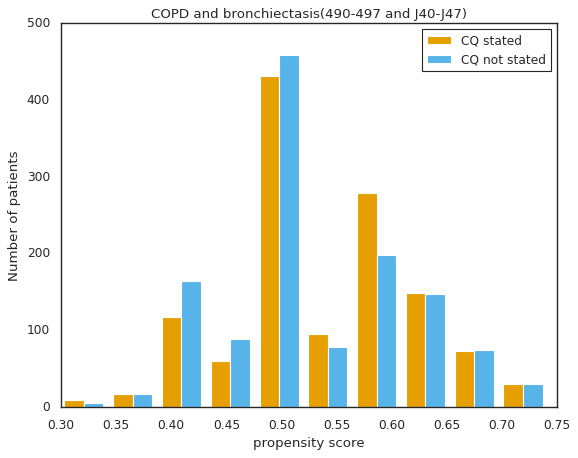

In [53]:
# logistic regression estimation plot
# title = "Pneumonia(486-J18.9)"
# file_name = "pneumonia(486-J189)"
title = "COPD and bronchiectasis(490-497 and J40-J47)"
file_name = "COPDandBronchlectasis"
psm_helper.psm.plot_match(Title=title, matched_entity='propensity_score',
                          Xlabel='propensity score', names=["CQ stated", "CQ not stated"], save=True, file_name=f"{file_name}_lr")

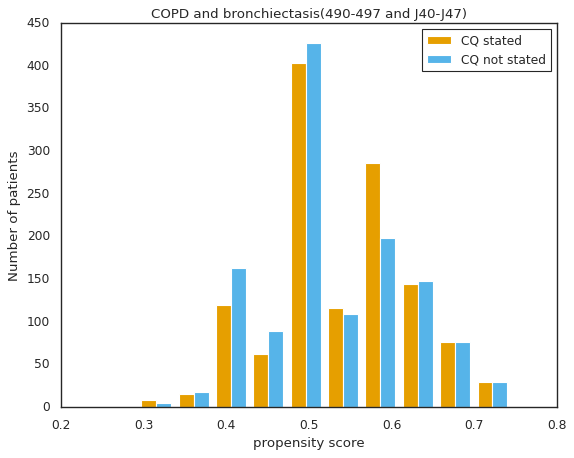

In [54]:
# neural network estimation plot
psm_helper_nn.psm.plot_match(Title=title, matched_entity='propensity_score', Xlabel='propensity score',
                             names=["CQ stated", "CQ not stated"], save=True, file_name=f"{file_name}_nn")

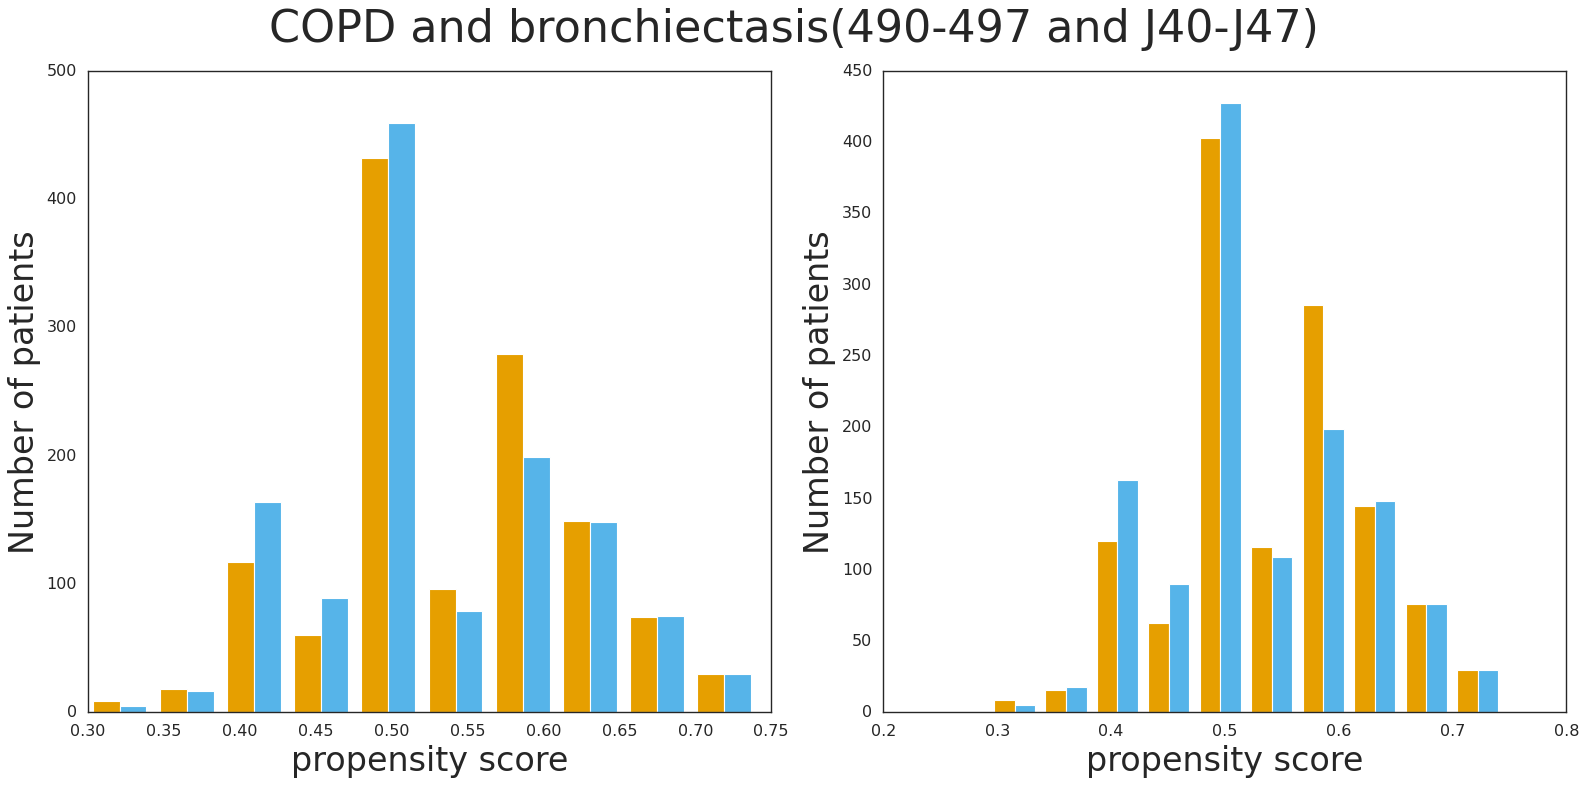

In [55]:
# title = "Pneumonia(486-J18.9)"
# file_name = "pneumonia(486-J189)"

title = "COPD and bronchiectasis(490-497 and J40-J47)"
file_name = "COPDandBronchlectasis"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
psm_helper.psm.plot_match_subplots(Title=title, matched_entity='propensity_score',
                          Xlabel='propensity score', names=["CQ stated", "CQ not stated"], axes=axes, idx=0)
psm_helper_nn.psm.plot_match_subplots(Title=title, matched_entity='propensity_score', Xlabel='propensity score',
                             names=["CQ stated", "CQ not stated"], axes=axes, idx=1)
fig.suptitle(title, fontsize=40)
fig.tight_layout()
plt.savefig(f'./plots_ps/{file_name}.pdf', dpi=250)

In [58]:
psm_helper.psm_stats_table()

['C0013404', 'C0024117', 'C0010200', 'C0004096', 'C4086268', 'C0242184', 'C0015967', 'C0043144', 'C0008031', 'C0239134', 'C0018802', 'C0332271', 'C0476273', 'C0349790', 'C1145670', 'age_intervall_0', 'age_intervall_1', 'age_intervall_2', 'M', 'F']
                            is_clinical_question_stated  C0013404            \
                                                  count      mean       std   
is_clinical_question_stated                                                   
0                                                  1265  0.483004  0.499909   
1                                                  1264  0.448576  0.497545   

                             C0024117            C0010200            C0004096  \
                                 mean       std      mean       std      mean   
is_clinical_question_stated                                                     
0                            0.156522  0.363493  0.223715  0.416898  0.091700   
1                            0.1

In [59]:
psm_helper_nn.psm_stats_table()

['C0013404', 'C0024117', 'C0010200', 'C0004096', 'C4086268', 'C0242184', 'C0015967', 'C0043144', 'C0008031', 'C0239134', 'C0018802', 'C0332271', 'C0476273', 'C0349790', 'C1145670', 'age_intervall_0', 'age_intervall_1', 'age_intervall_2', 'M', 'F']
                            is_clinical_question_stated  C0013404            \
                                                  count      mean       std   
is_clinical_question_stated                                                   
0                                                  1265  0.483004  0.499909   
1                                                  1264  0.446994  0.497379   

                             C0024117            C0010200            C0004096  \
                                 mean       std      mean       std      mean   
is_clinical_question_stated                                                     
0                            0.156522  0.363493  0.223715  0.416898  0.091700   
1                            0.1

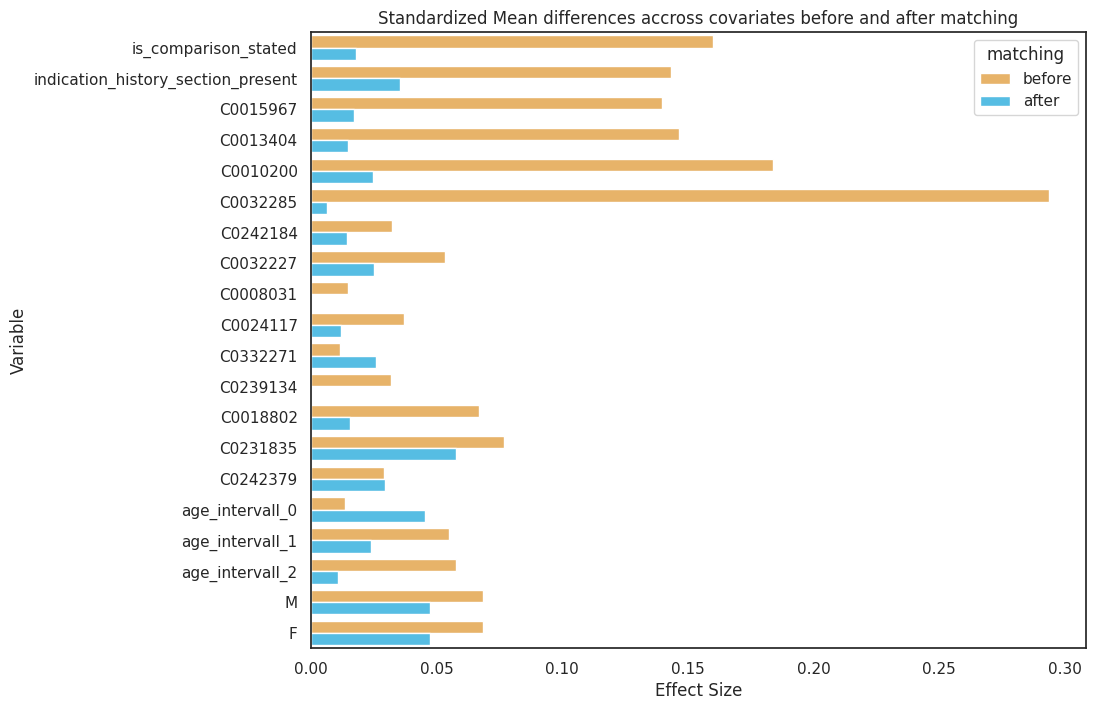

In [32]:
psm_helper.psm.effect_size_plot(save=False)

## Causal effect estimates

In [19]:
print("Cardiomegaly-Treatment: ", psm_helper.df_matched_treatment["Cardiomegaly_is_stated"].mean())
print("Cardiomegaly-Control  : ", psm_helper.df_matched_control["Cardiomegaly_is_stated"].mean())

print("Atelectasis-Treatment : ", psm_helper.df_matched_treatment["Atelectasis_is_stated"].mean())
print("Atelectasis-Control   : ", psm_helper.df_matched_control["Atelectasis_is_stated"].mean())

print("Pleural_Other-Treatment : ", psm_helper.df_matched_treatment["Pleural_Other_is_stated"].mean())
print("Pleural_Other-Control   : ", psm_helper.df_matched_control["Pleural_Other_is_stated"].mean())

print("Pneumonia-Treatment : ", psm_helper.df_matched_treatment["Pneumonia_is_stated"].mean())
print("Pneumonia-Control   : ", psm_helper.df_matched_control["Pneumonia_is_stated"].mean())

print("Pneumothorax-Treatment : ", psm_helper.df_matched_treatment["Pneumothorax_is_stated"].mean())
print("Pneumothorax-Control   : ", psm_helper.df_matched_control["Pneumothorax_is_stated"].mean())
# psm_helper.df_matched_control

Cardiomegaly-Treatment:  0.2572298325722983
Cardiomegaly-Control  :  0.1917808219178082
Atelectasis-Treatment :  0.2579908675799087
Atelectasis-Control   :  0.273972602739726
Pleural_Other-Treatment :  0.0136986301369863
Pleural_Other-Control   :  0.0182648401826484
Pneumonia-Treatment :  0.5882800608828006
Pneumonia-Control   :  0.65220700152207
Pneumothorax-Treatment :  0.1796042617960426
Pneumothorax-Control   :  0.12557077625570776


## Sensitivity Analysis

In [26]:
%%time
# test_stats_dict = dict.fromkeys(OBSERVATIONAL_CLASSES, [])
test_stats_dict = {
    "run_id": [],
    "pathology": [],
    "chi2": [],
    "p_value": [],
    "is_significant": []
}

for run_id, symptoms in enumerate(observation_indication_history):
    symptoms_list = observation_indication_history_cuis[0:(run_id + 1)]
    print("(", run_id, ")", " Estimation for: ", symptoms_list)

    psm_helper = PsmHelper(data=df_data,
                           patient_characteristics=patient_characteristics,
                           custom_confounders=[],
                           indication_cuis=observation_indication_history_cuis[0:(run_id + 1)],
                           treatment_var=treatment_var,
                           spec_cq_cui=None)
    psm_helper.generate_psm_data(icd_code=disease_icd,
                                 apply_cond_filter=False)
    psm_helper.psmpy_prop_score_log_reg()
    psm_helper.psmpy_knn(matcher="propensity_score",
                         replacement=False)
    test_stats = psm_helper.psmpy_chi2_test_results()

    for idx, row in test_stats.iterrows():
        test_stats_dict["run_id"].append(run_id)
        test_stats_dict["pathology"].append(row["pathology"])
        test_stats_dict["chi2"].append(row["chi2"])
        test_stats_dict["p_value"].append(row["p_value"])
        test_stats_dict["is_significant"].append(row["is_significant"])

( 0 )  Estimation for:  ['C0035522']
knn_matched_one_one(matcher=matcher, replacement=replacement, caliper=caliper)
( 1 )  Estimation for:  ['C0035522', 'C0032326']
knn_matched_one_one(matcher=matcher, replacement=replacement, caliper=caliper)
( 2 )  Estimation for:  ['C0035522', 'C0032326', 'C0008034']
knn_matched_one_one(matcher=matcher, replacement=replacement, caliper=caliper)
( 3 )  Estimation for:  ['C0035522', 'C0032326', 'C0008034', 'C1421211']
knn_matched_one_one(matcher=matcher, replacement=replacement, caliper=caliper)
( 4 )  Estimation for:  ['C0035522', 'C0032326', 'C0008034', 'C1421211', 'C0030899']
knn_matched_one_one(matcher=matcher, replacement=replacement, caliper=caliper)
( 5 )  Estimation for:  ['C0035522', 'C0032326', 'C0008034', 'C1421211', 'C0030899', 'C0019123']
knn_matched_one_one(matcher=matcher, replacement=replacement, caliper=caliper)
( 6 )  Estimation for:  ['C0035522', 'C0032326', 'C0008034', 'C1421211', 'C0030899', 'C0019123', 'C0043251']
knn_matched_one

In [27]:
df_test_stats = pd.DataFrame(test_stats_dict)
df_test_stats

,run_id,pathology,chi2,p_value,is_significant
0,0,Atelectasis,0.184915,0.667183,False
1,0,Cardiomegaly,13.768217,0.000207,True
2,0,Consolidation,0.429601,0.512185,False
3,0,Edema,0.097948,0.754306,False
4,0,Enlarged_Cardiomediastinum,0.264604,0.606975,False
...,...,...,...,...,...
289,20,Pleural_Effusion,0.183167,0.668666,False
290,20,Pleural_Other,0.000000,1.000000,False
291,20,Pneumonia,0.134135,0.714183,False
292,20,Pneumothorax,0.066569,0.796399,False


In [28]:
df_plot_p_value = pd.pivot(df_test_stats[["run_id", "pathology", "p_value"]], index="run_id", columns="pathology",
                           values="p_value")
df_plot_chi2 = pd.pivot(df_test_stats[["run_id", "pathology", "chi2"]], index="run_id", columns="pathology",
                        values="chi2")
df_plot_is_significant = pd.pivot(df_test_stats[["run_id", "pathology", "is_significant"]], index="run_id",
                                  columns="pathology", values="is_significant")
df_plot_p_value

pathology,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged_Cardiomediastinum,Fracture,Lung_Lesion,Lung_Opacity,No_Finding,Pleural_Effusion,Pleural_Other,Pneumonia,Pneumothorax,Support_Devices
run_id,,,,,,,,,,,,,,
0,0.667183,0.000207,0.512185,0.754306,0.606975,0.262253,0.338416,0.260413,0.801751,0.232788,0.542487,0.470877,0.260108,0.131659
1,0.931076,0.000207,0.512185,0.677430,0.892846,0.195175,0.338416,0.221888,0.708066,0.494161,0.261627,0.402615,0.489950,0.155438
2,1.000000,0.000103,0.697848,0.834204,1.000000,0.068442,0.338416,0.350124,1.000000,0.201280,0.749651,0.341226,0.298947,0.052376
3,1.000000,0.000559,0.797026,1.000000,1.000000,0.045612,0.338416,0.456418,1.000000,0.442017,1.000000,0.714183,0.489950,0.042762
4,0.492251,0.000072,0.797026,0.356633,1.000000,0.014510,0.338416,0.781892,0.897034,0.306010,1.000000,0.545852,0.863999,0.014136
5,0.931278,0.000404,0.697848,0.916379,0.786134,0.005042,0.542487,1.000000,0.897034,0.494161,1.000000,0.402615,0.730666,0.034698
6,0.440049,0.000207,0.602399,0.307150,0.522797,0.056077,0.338416,0.577812,0.506528,0.347859,1.000000,1.000000,0.387447,0.006752
7,0.796134,0.000008,0.512185,0.307150,1.000000,0.045612,0.178878,0.515371,0.694125,0.347859,1.000000,0.901774,0.730666,0.006752
8,0.667183,0.000147,0.428506,1.000000,0.895706,0.045612,0.338416,0.577812,1.000000,0.494161,1.000000,1.000000,0.863519,0.008692


In [29]:
fig = px.line(df_plot_p_value, x=df_plot_p_value.index, y=df_plot_p_value.columns, log_y=False,
              labels={"run_id": "symptoms", "value": "p-value"},
              title="Chi2 p_value effect significance")
fig.add_hline(y=0.05, line_width=2, line_dash="dash", line_color="green")
fig.show()

In [30]:
fig = px.line(df_plot_p_value, x=df_plot_p_value.index, y=df_plot_p_value.columns, log_y=True,
              labels={"run_id": "symptoms", "value": "p-value"},
              title="Chi2 p_value effect significance")
fig.add_hline(y=0.05, line_width=2, line_dash="dash", line_color="green")
fig.show()

In [31]:
fig = px.line(df_plot_is_significant, x=df_plot_is_significant.index, y=df_plot_is_significant.columns, markers=True,
              title="Effect significance")
fig.show()

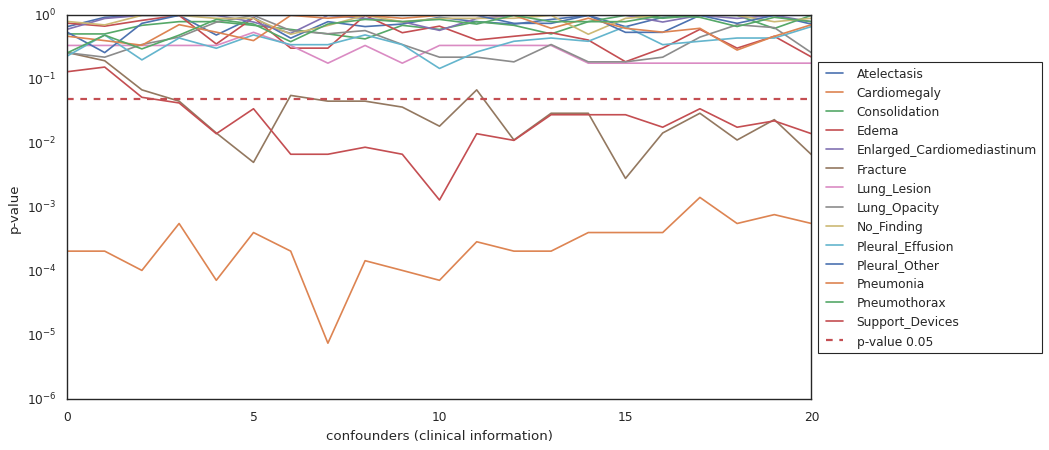

In [32]:
# with plt.style.context(['science','no-latex']):
fig = plt.figure(figsize=(15, 6))
plt.xlim(0, df_plot_p_value.index[-1])
ax = plt.subplot(111)
ax.set_yscale('log')
# df_plot_p_value.plot().legend(loc="lower left")
for e in df_plot_p_value.columns:
    ax.plot(df_plot_p_value.index, df_plot_p_value[e], label=e)
ax.hlines(y=0.05, xmin=0, xmax=df_plot_p_value.index[-1], linewidth=2, color='r', linestyles='--', label="p-value 0.05")
plt.xlabel("confounders (clinical information)")
plt.ylabel("p-value")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(
    # f"C:/Users/mjantscher/PycharmProjects/PhD/mimiciv/src/propensity_score_matching/plots/log_reg_0_all_pvalue.png")
    # f"C:/Users/mjantscher/PycharmProjects/PhD/mimiciv/src/propensity_score_matching/plots/log_reg_0_pvalue.png")
    # f"/home/mijantscher/PycharmProjects/mimiciv/src/propensity_score_matching/plots/log_reg_486_j189_all_pvalue.png")
    f"/home/mijantscher/PycharmProjects/mimiciv/src/propensity_score_matching/plots/log_reg_807_s22_all_pvalue.png")
plt.show()

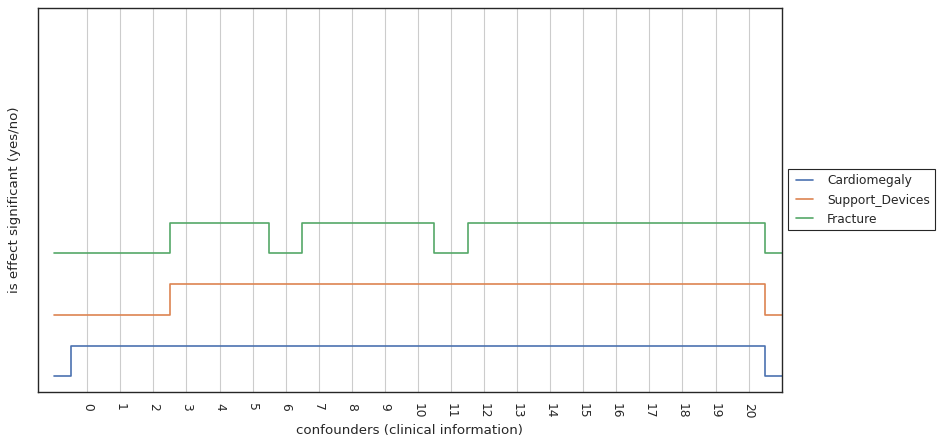

In [33]:
def binary_data(data, yshift=0):
    return [yshift] + [yshift + 1 if x == True else yshift for x in data] + [yshift]


fig = plt.figure(figsize=(15, 6))
plt.ylim(-0.5, 12)
plt.xlim(-1.5, df_plot_is_significant.index[-1] + 1)
plt.xticks(rotation=-90)

ax = plt.subplot(111)
ax.set_xticks(list(df_plot_is_significant.index.values))
ax.set_yticklabels([])
ax.grid(axis="x")
# df_plot_p_value.plot().legend(loc="lower left")
for shift, e in enumerate(df_plot_is_significant[
                              ["Cardiomegaly", "Support_Devices", "Fracture"]]):
    # if e not in ["Atelectasis", "Cardiomegaly", "Lung_Opacity", "Pleural_Effusion", "Pneumonia", "Pneumothorax"]:
    #     continue
    # ax.plot(df_plot_is_significant.index, df_plot_is_significant[e], label=e)
    bindata = binary_data(df_plot_is_significant[e], 2 * shift)
    last_x_value = df_plot_is_significant.index.values[len(df_plot_is_significant.index.values) - 1] + 1
    ax.step([-1] + list(df_plot_is_significant.index.values) + [last_x_value], bindata, where="mid", label=e)
plt.xlabel("confounders (clinical information)")
plt.ylabel("is effect significant (yes/no)")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(
    # f"C:/Users/mjantscher/PycharmProjects/PhD/mimiciv/src/propensity_score_matching/plots/log_reg_0_all_significance.png")
    # f"/home/mijantscher/PycharmProjects/mimiciv/src/propensity_score_matching/plots/log_reg_486_j189_all_significance.png")
    f"/home/mijantscher/PycharmProjects/mimiciv/src/propensity_score_matching/plots/log_reg_807_s22_all_significance.png")
plt.show()